# Classification in python using scikit-learn: real data

Much of this tutorial is based on, or inspired by, the longer fMRI-pattern-analysis course developed by Lukas Snoek at the University of Amsterdam: https://lukas-snoek.com/NI-edu/index.html. It was first created by Daniel.Mitchell@mrc-cbu.cam.ac.uk, then adapted very slightly by Rik.Henson@mrc-cbu.cam.ac.uk

- **Last updated:** November 2024 by [Rik Henson](https://www.mrc-cbu.cam.ac.uk/people/rik.henson/) 
- **conda environment**: Needs the [fMRI workshop's conda environment](https://github.com/MRC-CBU/COGNESTIC/blob/main/mri_environment.yml) to run this notebook and any accompanied scripts.

## Getting Ready

As usual, we need some python packages like below:

In [1]:
import numpy as np              # This lets python process matrices, like Matlab
import matplotlib.pyplot as plt # This lets python plot graphs like Matlab
import seaborn as sns           # This provides another popular set of plotting functions
import pandas as pd             # To use "dataframes" (like tables in Matlab)
import os                       # To interact with the operating system, including files and paths (e.g. path.join)
import os.path as op            # for file path operations
import time                     # To use "time" (like "tic" in Matlab)

# Nilearn modules, for the analysis of brain volumes, plotting, etc., https://nilearn.github.io/
import nilearn as nl           # Many useful functions for MRI, including...
from nilearn import image       # to load (load_img), resample (resample_to_img), manipulate (math_img) fMRI data, etc.
from nilearn import datasets    # includes e.g. fetch_atlas_harvard_oxford
from nilearn import masking
from nilearn import input_data  # includes NiftiMasker, NiftiLabelsMasker
from nilearn import plotting    # includes plot_roi, plot_stat_map, view_img_on_surf, etc.
from nilearn import decoding    # includes Searchlight
from nilearn.plotting import plot_design_matrix, plot_contrast_matrix, plot_stat_map, plot_roi
from nilearn.glm.first_level import FirstLevelModel, compute_regressor, spm_hrf
from nilearn.glm.thresholding import threshold_stats_img
from nilearn.maskers import NiftiSpheresMasker

from bids.layout import BIDSLayout # to fetch data from BIDS-compliant datasets

import nibabel as nib # NiBabel, to read and write neuroimaging data, https://nipy.org/nibabel/

# scikit-learn is the major library for machine learning in Python:
import sklearn as skl
from sklearn import preprocessing   # includes LabelEncoder, OneHotEncoder, Standardzscorer...
from sklearn import decomposition   # includes PCA
from sklearn import model_selection # includes StratifiedKFold, LeaveOneGroupOut, etc....
from sklearn import linear_model    # includes LogisticRegression, RidgeClassifier...
from sklearn import svm             # includes SVC, NuSVC & LinearSCV...
from sklearn import discriminant_analysis # includes LinearDiscriminantAnalysis
from sklearn import metrics         # includes accuray, balanced accuracy, roc_auc_score, etc....
from sklearn import pipeline        # includes make_pipeline
from sklearn import inspection      # includes DecisionBoundaryDisplay

%matplotlib inline

In [2]:
wd = '/mnt/c/Users/rh01/PythonNeuroimagingCourse/FaceProcessing/' # <-- CHANGE TO YOURS
os.chdir(wd)
#print(f"Working directory currently {os.getcwd()}")

# Make new directory for output
output = os.path.join(wd, 'mvpa')
if not os.path.exists(output):
    os.makedirs(output)
print(f"Output directory {output}")

Output directory /mnt/c/Users/rh01/PythonNeuroimagingCourse/FaceProcessing/mvpa


In [3]:
fmri_data_dir = 'data' # data in BIDS format
fmri_results_dir = 'results' # results in BIDS format

# --- Set up the BIDS layout
layout = BIDSLayout(fmri_data_dir, derivatives = True)
# Attach the results folder to the layout. 
layout.add_derivatives(os.path.join(fmri_results_dir, "first-level"))

## Extracting trial-specific responses (Betas)

We are going to try to classify famous versus unfamiliar faces. 

We first need to extract estimates for every trial that contained a famous or unfamiliar faces, restricting ourselves to initial presentations.

One way - so-called **Least-Squares-All** (LSA) simply involves creating a new regressor for each trial (i.e, using a single event onset). This can be appropriate in some situations, but generally results in quite noisy Beta estimates. An alternative is **Least-Squares-Separate** (LSS) which 


In [4]:
sID = '15'
bold = layout.get(subject = sID, datatype = 'func', desc = 'preproc', extension = '.nii.gz', return_type = 'filename')
print("Found " + str(len(bold)) + " preprocessed functional files")

Found 9 preprocessed functional files


In [5]:
events_files = layout.get(subject=sID, datatype='func', suffix='events', extension=".tsv", return_type='filename')
print("Found " + str(len(events_files)) + " event files")

Found 9 event files


In [6]:
conditions = ['IniFF', 'ImmFF', 'DelFF', 'IniUF', 'ImmUF', 'DelUF', 'IniSF', 'ImmSF', 'DelSF']
#conditions_of_interest = ['IniFF', 'ImmFF', 'DelFF', 'IniUF', 'ImmUF', 'DelUF']
#conditions_of_interest = ['IniFF', 'IniUF']
#conditions_of_interest = ['IniFF', 'DelFF', 'IniUF', 'DelUF']
conditions_of_interest = ['IniFF', 'DelFF', 'IniSF', 'DelSF']
other_conditions = [val for val in conditions if val not in conditions_of_interest]

In [7]:
lsa_events = []
for run, events_file in enumerate(events_files):
    events_df = pd.read_table(events_file)
    for j, event in enumerate(events_df['trial_type']):
        if event in conditions_of_interest:
            events_df.loc[j, 'trial_type'] = event + events_df['stim_file'][j][-8:-4]
    events_df = events_df.drop(columns = ['button_pushed', 'stim_file', 'trigger', 'circle_duration', 'response_time'])
    lsa_events.append(events_df)

print(lsa_events[0])

      onset  duration trial_type
0     0.000     0.910  IniFFf005
1     3.124     0.996  IniFFf012
2     6.564     0.830      ImmFF
3     9.620     0.908  IniSFs007
4    12.894     0.885      IniUF
..      ...       ...        ...
88  380.126     0.914      DelUF
89  383.250     0.896      IniUF
90  386.423     0.818      DelUF
91  389.480     1.000      IniUF
92  392.804     0.955      ImmUF

[93 rows x 3 columns]


In [8]:
# Get the confounds of interest
confound_files = layout.get(subject = sID, datatype = 'func', desc = 'confounds', extension = ".tsv", return_type = 'filename')
relevant_confounds = ['trans_x', 'trans_y', 'trans_z', 'rot_x', 'rot_y', 'rot_z']
confounds_for_glm = []
for conf_file in confound_files:
    this_conf = pd.read_table(conf_file)
    conf_subset = this_conf[relevant_confounds].fillna(0) # replace NaN with 0
    confounds_for_glm.append(conf_subset)

TR = layout.get_tr()
print('TR:', TR)
slice_timing = layout.get_metadata(bold[0])
if slice_timing['SliceTimingCorrected']:
  slice_time_ref = slice_timing['StartTime'] / TR
  print('Slice timing reference:', slice_time_ref)

TR: 2.0
Slice timing reference: 0.486


Note - no smoothing and no signal scaling; see https://nilearn.github.io/dev/auto_examples/07_advanced/plot_beta_series.html

No scaling - cite signal_scaling help

In [9]:
brain_mask_file = layout.get(return_type='file', datatype='func', suffix='mask', desc='brain', space='MNI152NLin2009cAsym', extension='nii.gz')[0]
brain_mask = nib.load(brain_mask_file)

fmri_glm = FirstLevelModel(t_r = TR,
                           slice_time_ref = slice_time_ref,
                           hrf_model = 'spm',
                           drift_model = 'cosine',
                           drift_order = 1,
                           high_pass = 0.01,
                           smoothing_fwhm = None,
                           signal_scaling = (0, 1), # grand mean scaling only
                           noise_model = 'ar1',
                           mask_img = brain_mask,
                           memory = 'scratch');
# fit for run 1
#run_glm = fmri_glm.fit(bold[0], lsa_events[0], confounds_for_glm[0]);

Design matrix for run 1


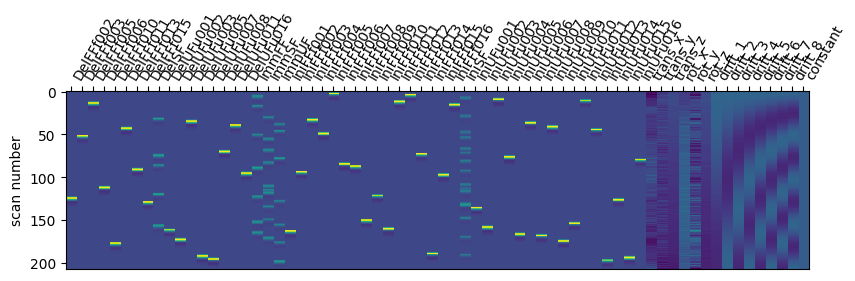

In [10]:
design_matrices = fmri_glm.design_matrices_
print('Design matrix for run', 1)
plot_design_matrix(design_matrices[0], output_file=None)
fig = plt.gcf()
fig.set_size_inches(8,2)
plt.show()

We now run through all 9 runs, fitting the GLM, calculating the effect size (beta) for each initial FF and UF trial (to save in a 4D image for each run) and also defining the labels associated with each trial, which we will need for classification later.

In [9]:
model_name = 'LSA_2FF_2SF' # need to add LSS
#model_name = 'LSA_2FF_2UF' # need to add LSS
outdir = os.path.join(output, model_name, 'sub-' + sID)
if not os.path.exists(outdir):
    os.makedirs(outdir)

In [ ]:
affine = nib.load(bold[0]).affine

lab_enc = skl.preprocessing.LabelEncoder() # this initialises the LabelEncoder object

img_4d_fname = []
labels_per_run = []
for run in range(len(bold)):
    # fit GLM
    run_glm = fmri_glm.fit(bold[run], lsa_events[run], confounds_for_glm[run]);
    
    # Compute betas for each initial FF and UF trial
    trials_to_save = lsa_events[run]["trial_type"]
    trials_to_save = [val for val in trials_to_save if val not in other_conditions]
    lsa_beta_maps  = [] 
    print(f'Run {run}: Creating {len(trials_to_save)} beta images...')
    for trial in trials_to_save:
        beta_map = run_glm.compute_contrast(trial, output_type = 'effect_size');
        #if want to save each trial as a separate beta image
        #beta_map.to_filename(os.path.join(outdir, os.path.basename(bold[0]).split("space")[0] + 'desc-' + trial + '_beta.nii.gz'))
        lsa_beta_maps.append(beta_map)

    # save trials as a 4D image so can load later
    print(f'Run {run}: Saving to a 4D file...')
    volumes = np.squeeze([lsa_beta_maps[trial].get_fdata() for trial in range(0,len(lsa_beta_maps))])
    data_4d = np.stack(volumes, axis=-1)  # Stack along the 4th dimension
    img_4d  = nib.Nifti1Image(data_4d, affine);
    img_4d_fname.append(os.path.join(outdir, os.path.basename(bold[run]).split("space")[0] + model_name + '_betas.nii.gz'))
    nib.save(img_4d, img_4d_fname[run]);

    # calculate labels associated with each trial
    trials_to_save = [label[3:5] for label in trials_to_save]
    labels_per_run.append(lab_enc.fit_transform(trials_to_save)) # Encode as integers, done alphabetically
 
# Remove the cached directory
!rm -rf scratch/joblib/

TBC:

In [11]:
fusi_ROI = nib.load(op.join(fmri_results_dir,'sphere_and_faces-scrambled_Zmap_fdr.nii.gz'))
# shouldn't need to resample fusi ROI, but just to be safe!
fusi_ROI = nl.image.resample_to_img(fusi_ROI, img_4d_fname[0], interpolation='nearest') # resample ROI to bold resolution to save time when estimating glm below

\
We don't expect all of these voxels to contain signal (some are not even in the brain!). So we will **select voxels from a Region Of Interest (ROI).** This is a type of **feature selection**, which restricts the analysis to brain regions we are interested in, and/or brain regions where we expect to find signal. To avoid biasing the results, any data used for feature selection must be independent of the data being classified. Since these data are in MNI space, we can use any mask independently defined in MNI space. Here, we'll use Nilearn to load anatomical ROIs from the Harvard-Oxford subcortical atlas. These are returned as a dictionary that stores the `filename`, `description` and, importantly, `labels` (ROI names) and `maps` (a 3D volume of integers that index the ROI names):


Now we can pass this ROI to a `masker` object, and apply it to the activation patterns:

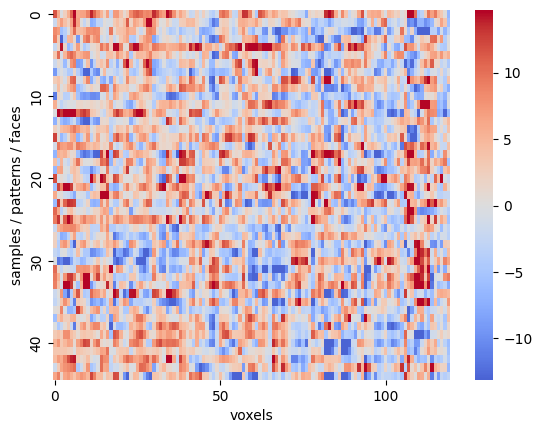

In [12]:
masker = nl.input_data.NiftiMasker(fusi_ROI)
#masker = nl.input_data.NiftiMasker(amyg_ROI)

patterns_4d = nl.image.load_img(img_4d_fname[0])
patterns_ROI = masker.fit_transform(patterns_4d) 

ax = sns.heatmap(patterns_ROI, cmap='coolwarm', center=0, robust=1, xticklabels=50, yticklabels=10)
ax.set(xlabel="voxels", ylabel="samples / patterns / faces");

\
We can see that some of these voxels are correlated, and some will be noisier than others. Classifiers are often able to handle this, but we may choose to apply **dimension reduction**. This is sometimes called **feature extraction**, and a common method is principle component analysis (**PCA**):

Shape of pattern matrix after PCA: (45, 10)


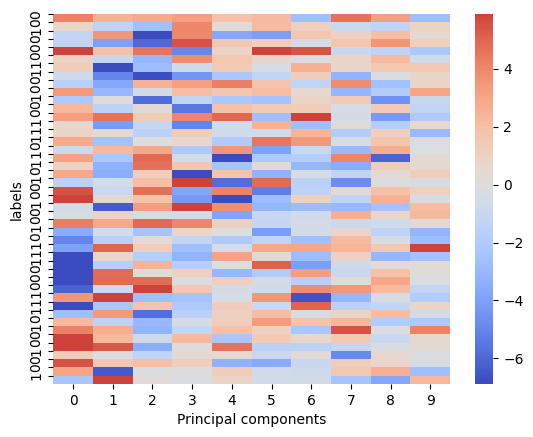

In [13]:
zscorer = skl.preprocessing.StandardScaler()
patterns_ROI = zscorer.fit_transform(patterns_ROI)

pca = skl.decomposition.PCA(n_components=10)
pca.fit(patterns_ROI)
patterns_ROI_PCA10 = pca.transform(patterns_ROI)

print("Shape of pattern matrix after PCA:", patterns_ROI_PCA10.shape)

ax = sns.heatmap(patterns_ROI_PCA10, cmap='coolwarm', center=0, robust=1, xticklabels=1, yticklabels=10)
ax.set(xlabel="Principal components", ylabel="labels");
ax.set_yticks(range(len(labels_per_run[0])));
ax.set_yticklabels(labels_per_run[0]);

Note that features are typically standardized before PCA, otherwise the principal components will be dominated by features with larger scales. However, standardization means that features that originally had low variance will be upweighted, under the assumption that all features are expected to be equally predictive. In fMRI, noisy/non-predictive features may have low variance, so upweighting them may be detrimental to performance.

\
Now let's put everything together: load data from all six runs of this day...

In [34]:
demeaner = skl.preprocessing.StandardScaler(with_std=False)

ROI_data_per_run   = [] # list of ROI's pattern matrices (one for each run)
brain_data_per_run = [] # also save the whole brain data for running a searchlight later

for run in range(len(img_4d_fname)):
    print(img_4d_fname[run])
    patterns_4d = nl.image.load_img(img_4d_fname[run]) 
    #patterns_4d = nl.image.clean_img(patterns_4d, standardize=True, detrend=False)
    patterns_ROI = masker.fit_transform(patterns_4d)

#    patterns_ROI = zscorer.fit_transform(patterns_ROI)

    patterns_ROI = demeaner.fit_transform(patterns_ROI.transpose()).transpose()
#    patterns_ROI = patterns_ROI - patterns_ROI.mean(axis=1, keepdims=True): 
    
    #pca.fit(patterns_ROI)
    #patterns_ROI = pca.transform(patterns_ROI)
    
    ROI_data_per_run.append( patterns_ROI )  # append this run's data to list
    brain_data_per_run.append( patterns_4d ) # whole-brain data that will use later in search light

/mnt/c/Users/rh01/PythonNeuroimagingCourse/FaceProcessing/mvpa/LSA_2FF_2SF/sub-15/sub-15_ses-mri_task-facerecognition_run-01_LSA_2FF_2SF_betas.nii.gz
/mnt/c/Users/rh01/PythonNeuroimagingCourse/FaceProcessing/mvpa/LSA_2FF_2SF/sub-15/sub-15_ses-mri_task-facerecognition_run-02_LSA_2FF_2SF_betas.nii.gz
/mnt/c/Users/rh01/PythonNeuroimagingCourse/FaceProcessing/mvpa/LSA_2FF_2SF/sub-15/sub-15_ses-mri_task-facerecognition_run-03_LSA_2FF_2SF_betas.nii.gz
/mnt/c/Users/rh01/PythonNeuroimagingCourse/FaceProcessing/mvpa/LSA_2FF_2SF/sub-15/sub-15_ses-mri_task-facerecognition_run-04_LSA_2FF_2SF_betas.nii.gz
/mnt/c/Users/rh01/PythonNeuroimagingCourse/FaceProcessing/mvpa/LSA_2FF_2SF/sub-15/sub-15_ses-mri_task-facerecognition_run-05_LSA_2FF_2SF_betas.nii.gz
/mnt/c/Users/rh01/PythonNeuroimagingCourse/FaceProcessing/mvpa/LSA_2FF_2SF/sub-15/sub-15_ses-mri_task-facerecognition_run-06_LSA_2FF_2SF_betas.nii.gz
/mnt/c/Users/rh01/PythonNeuroimagingCourse/FaceProcessing/mvpa/LSA_2FF_2SF/sub-15/sub-15_ses-mri_tas

\
...and try to decode expression within the amygdala ROI, using leave-one-run-out cross-validatation. This time we'll use yet another classifier - a Fisher's linear discriminant classifer:

In [40]:
nruns=(len(ROI_data_per_run))
run_indices = np.concatenate([[i] * np.size(ROI_data_per_run[i],axis=0) for i in range(nruns)])
all_data    = np.concatenate(ROI_data_per_run, axis=0) # concatenate data across runs
all_labels  = np.concatenate(labels_per_run, axis=0) # concatenate labels across runs

print(all_data.shape)
print(all_labels.shape)

(414, 120)
(414,)


In [41]:
fac = all_data[all_labels==0]
scr = all_data[all_labels==1]
print(np.mean(fac), np.mean(scr))
print(lab_enc.fit_transform(['FF','SF']))

-1.67580833905684e-17 -6.097066379459606e-17
[0 1]


In [44]:
#LDA  = skl.discriminant_analysis.LinearDiscriminantAnalysis();
pca  = skl.decomposition.PCA(); 
zscorer = skl.preprocessing.StandardScaler();
#pipe = pipeline.make_pipeline(LDA)
from sklearn.pipeline import Pipeline
#pipe = Pipeline(steps=[("zscorer", zscorer), ("pca", pca), ("LDA", LDA)])
logistic = skl.linear_model.LogisticRegression(max_iter=10000, tol=0.1)
#pipe = pipeline.make_pipeline(logistic)
pipe = Pipeline(steps=[("zscorer", zscorer), ("pca", pca), ("Logistic", logistic)])
#pipe = Pipeline(steps=[("zscorer", zscorer), ("Logistic", logistic)])

In [45]:
logo = skl.model_selection.LeaveOneGroupOut()
fold_score = skl.model_selection.cross_val_score(pipe, all_data, all_labels, groups = run_indices,
                                    scoring = 'roc_auc', cv = logo)
observed_score = np.mean(fold_score)
print("Cross-validated score per fold:", fold_score)  
print("Mean cross-validated score:  ", observed_score)

Cross-validated score per fold: [0.67857143 0.61284722 0.56571429 0.62939959 0.50727273 0.55869565
 0.66493056 0.6155303  0.60989011]
Mean cross-validated score:   0.6047613189279857


Of course, classification can also be repeated and averaged across all subjects, but not done here.

Cross-validated score per fold: [0.67857143 0.61284722 0.56571429 0.62939959 0.50727273 0.55869565
 0.66493056 0.6155303  0.60989011]
Mean cross-validated score:   0.6047613189279857

## Significance testing

This is only just above chance. Is it significantly above chance? (See Rik's lectures.) We cannot test this using a t-test across folds, because the folds are not independent (they share training data). If we had multiple participants we could use a **one-sample t-test across participants**, versus chance. This is valid (assuming the specified chance level is correct) because participants are independent. For "within-context" cross-validation, below-chance accuracy is not meaningful (the true value can't be negative), which means we can use a one-tailed test; it also means that the test only provides fixed-effects rather than random-effects inference (see Allefeld et al., 2016). For cross-validation that generalises *across* contexts (e.g. train the classifer to decode the expression of younger faces, then test decoding of the expression of older faces) negative performance *could* be meaningful, so random-effects inference is justified. Similarly, when comparing classfication performance across conditions (e.g. is the performance of expression decoding for younger faces different from that for older faces?), paired-tests or repeated-measures ANOVA allow random-effects inference.

If we want **to assess significance for a single participant, we would need a permutation test**. (Actually this applies to testing the significance of any single *classification* that can't be repeated across independent samples, e.g. a single classification of the disease status of multiple partarticipants.) The permutation test involves shuffling the labels many times (e.g. 10,000) to generate a null distribution of classifier performance that would be expected under the null hypothesis of no difference between classes.

In some situations, permutation tests may be necessary, but they do have disadvantages:
 - the large number of required permutations makes them slow
 - low numbers of samples limit the number of unique permutations, which limits robustness of the p-value
 - there's some complexity in ensuring the labels are actually "exchangeable"

First we'll code this explicitly within the cross-validation loop:

In [140]:
folds = tuple(logo.split(all_data, all_labels, run_indices))

n_permutations = 200 # this is not nearly enough, but it will still take a while
permuted_scores = np.zeros(n_permutations)
print(f'Permuting {n_permutations} times:')
tic = time.time()
for p in range(n_permutations):
    
    fold_score=np.full(nruns,np.nan)
    for i, fold in enumerate(folds):
        train_idx, test_idx = fold   

        #### previously we trained the classifier like this:
        # pipe.fit( all_data[train_idx,:], all_labels[train_idx] )
        #### now we want to do something like this:
        # pipe.fit( all_data[train_idx,:], np.random.shuffle(all_labels[train_idx]) )
        #### but confusingly, we need to break it up like this:
        train_labels = all_labels[train_idx] 
        np.random.shuffle(train_labels)
        pipe.fit(all_data[train_idx,:], train_labels)
        #### because indexing makes a temporary copy, and shuffle operates in-place

        predicted_probabilities = pipe.predict_proba(all_data[test_idx,:]) # do prediction on test data
        fold_score[i] = skl.metrics.roc_auc_score(all_labels[test_idx], predicted_probabilities[:,1]) # syntax for binary classifcation
    permuted_scores[p] = np.mean(fold_score)
    print('.',end='')
print('Done.')
print('Took ', time.time()-tic,' s')

Permuting 200 times:
........................................................................................................................................................................................................Done.
Took  259.3320188522339  s


Now let's plot the observed score and compare it to the null distribution of scores from permuted data:

p vlaue =  0.004975124378109453


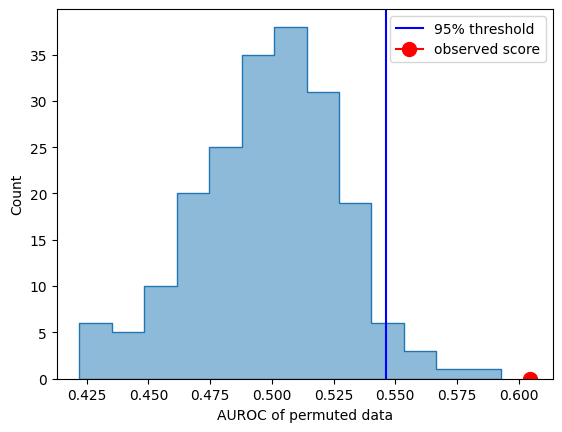

In [141]:
ax = sns.histplot(permuted_scores, element='step', alpha=0.5)
ax.set(xlabel = 'AUROC of permuted data');
lh = ax.axvline(np.percentile(permuted_scores, 95), color='b',label='95% threshold')
mh = ax.plot(observed_score, 0, marker='o', color='r', markersize=10, label='observed score')
ax.legend();

p = (sum(permuted_scores > observed_score) + 1) / (n_permutations + 1)
print('p vlaue = ', p)

In this case, there is no evidence for significant classification of expression within this ROI.

\
Just as scikit-learn has a function (`cross_val_score`) to simplify the cross-validation loop, it also has a similar function (`permutation_test_score`) to simplify the permutation process. This also allows the permutation to be run in parallel, which can be much faster! 

In [82]:
n_permutations = 1000 # this is more like it, but it will still take a while

tic = time.time()

actual_score, permuted_scores, p = skl.model_selection.permutation_test_score(pipe, all_data, all_labels, groups = run_indices,
                                    scoring = 'roc_auc', cv = logo, n_permutations = n_permutations, n_jobs = -1, random_state = None)

print('Took ', time.time()-tic,' s')
print("p value = ", p)

Took  24.00412893295288  s
p value =  0.000999000999000999


This p-value should, on average, be similar to above, but will differ because of the randomness of the permutations. As the number of unique permutations increases, the p-values from different repetitions should become more similar, giving an idea of the robustness of the permutation-p-value.

\
So far we have considered a single ROI. If we want to know where in the brain a representation is strongest, we can compare multiple ROIs. Sometimes we might be interested in discrete regions that cover the brain (e.g. an atlas/parcellation), but if we want a spatially continuous output, without making assumptions about area borders, we can use a "searchlight". 

## Searchlight analysis

A searchlight is not really anything special. It's just a set of overlapping ROIs, often spherical, that cover the brain (or analysis mask of interest). Each searchlight's classification performance is typically assigned to its central voxel. The inferences one would make are very similar to a voxel-wise, mass-univariate analysis of smoothed data (see Dace's sessions). Increasing the size of the searchlight reduces the spatial specificity of the inference, while tending to increase sensitivity, in a very similar way to increasing the smoothing kernal in univariate analysis. Similarly to the matched-filter theorem for univariate analyses, the optimal searchlight size will depend on the spatial scale of the signal and the spatial scale of the noise. It is sometimes assumed that searchlights need to be spatially contiguous, because they usually are, but the definition of a searchlight is just as flexible as the definition of any ROI. 

A searchlight analysis can be set up using nilearn's `.searchlight` object. This *is* restricted to contiguous spherical searchlights. When the searchlight object is created, it needs to be given a mask specifying which voxels will be included in the searchlights. So first we'll get an analysis mask that covers the whole brain. As before, we can load a template-space mask from nilearn, and resample it to match the data: 

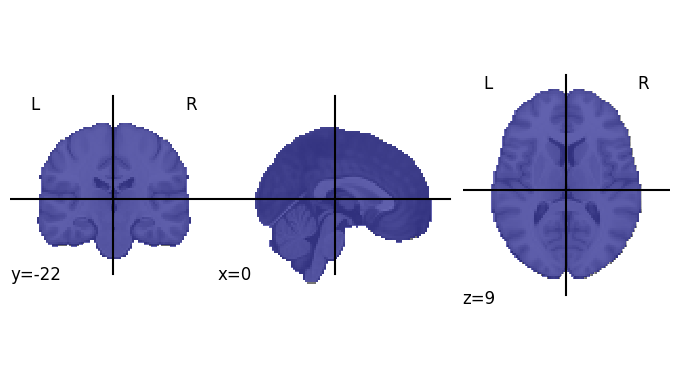

In [19]:
brain_mask = nl.datasets.load_mni152_brain_mask()
brain_mask = nl.image.resample_to_img(brain_mask, patterns_4d, interpolation='nearest')

#has_data =   nl.image.math_img('(img.prod(axis=3) !=0)', img=patterns_4d); # not zero for any sample
#brain_mask = nl.image.math_img('(in_mask & has_data)', in_mask=brain_mask, has_data=has_data);

display = nl.plotting.plot_roi(brain_mask,alpha=0.6);

\
We can also provide a second, optional mask that specifies where the searchlights are centred. To save some time, we'll constrain these to be in cortical grey matter of the left hemisphere. We could also load a grey-matter mask from nilearn, but here we'll use the 'Left Cerebral Cortex' region of the atlas we loaded earlier:

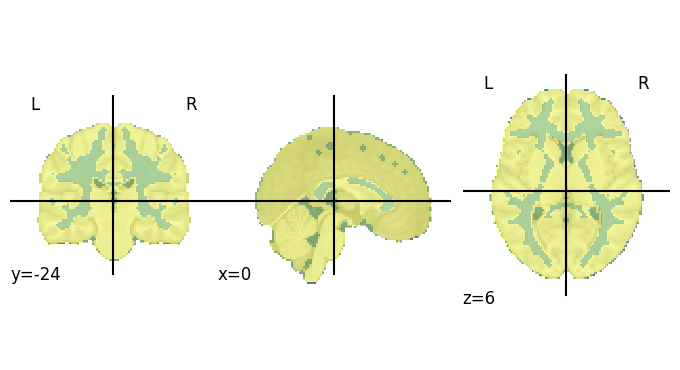

In [20]:
gm_mask = nl.datasets.load_mni152_gm_mask()
gm_mask = nl.image.resample_to_img(gm_mask, patterns_4d, interpolation='nearest')

# this is a subcortical, maximum-probability, anatomical atlas, thresholded at 25%, with 2 mm resolution
#HO_atlas = nl.datasets.fetch_atlas_harvard_oxford('sub-maxprob-thr25-2mm',data_dir) 
#print("\nROI names:\n", HO_atlas['labels'])
#print("\nShape of ROI map:\n", HO_atlas['maps'].shape)
#nl.plotting.plot_roi(HO_atlas['filename']);
#l_cortex_id = HO_atlas['labels'].index('Left Cerebral Cortex')                                # get the ID of the Left Cerebral Cortex
#gm_mask     = nl.image.math_img(f'(map == {l_cortex_id} )', map=resampled_ROI_map)           # create binary mask of this ROI
#gm_mask     = nl.image.math_img('(in_mask & has_data)', in_mask=gm_mask, has_data=has_data); # restrict mask to voxels that have data

display = nl.plotting.plot_roi(nl.image.math_img('a+2*b', a=gm_mask, b=brain_mask),alpha=0.6,cmap='summer');

In [28]:
import nibabel
import nibabel.processing
downsampled_brain_mask = nibabel.processing.resample_to_output(brain_mask, [3, 3, 3])
downsampled_gm_mask = nibabel.processing.resample_to_output(gm_mask, [3, 3, 3])

print(downsampled_gm_mask.shape)

(65, 77, 65)


Now we can create the `searchlight` object. We will also specify some other optional inputs, explained in the code below:

In [29]:
#pipe = skl.pipeline.make_pipeline(LDA) # we won't do PCA, because this would fail for some searchlights (think about why)

sl = nl.decoding.SearchLight(
    mask_img = downsampled_brain_mask,       # only include these voxels within searchlights
    process_mask_img = downsampled_gm_mask,  # only centre searchlights on these voxels 
    radius = 6,                  # in mm
    estimator = pipe,            # a classifier or pipeline object
    n_jobs = -1,                 # how many CPUs to use (-1 means the maximum available)
    scoring = 'roc_auc',         # choice of scoring metric
    cv = logo,                   # cross-validation object
    verbose = False              # this is slow, so if running locally (1 job) set it to true to know how far it's got; when running in parallel it produces too much output, so set to false
)

\
To launch the searchlight analysis, call the `searchlight` object's `.fit` method, passing it the patterns, the labels, and optionally the groups for cross-validation.
This will take a while (probably about 5 minutes on the virtual machine, with 4 cores)...

In [ ]:
#%%capture result
from IPython.utils import io
    
all_data = nl.image.concat_imgs(brain_data_per_run); # concatenate 4D nifti files from each run (along the 4th dimension)

print('Shape of 4D nifti data:', all_data.shape)
print('Shape of mask:', sl.mask_img.shape)
print('Shape of process_mask:', sl.process_mask_img.shape)

print('Running searchlight...')
tic = time.time()

np.seterr(invalid='ignore')

#with io.capture_output() as result:
sl.fit(all_data, all_labels, groups=run_indices);

print('Took ', time.time()-tic,' s')

In [4]:
#print("out:", result.stdout)
print("err:", result.stderr)

\
The output (here, mean AUROC) per voxel is stored in the  `scores_` property of the searchlight object (as a 3D numpy array). If we convert this to a nifti volume, we can plot it using nilearn. We'll also subtract chance (here, 0.5), so that positive and negative values will indicate above- and below-chance decoding performance:

In [ ]:
print('Shape of output numpy array: ', sl.scores_.shape)
scores = sl.scores_ - 0.5 # subtract chance
score_img = nl.image.new_img_like(brain_mask, sl.scores_ - 0.5); # save in samme format as the brain_mask
score_img = nl.image.math_img('score_img * processing_mask', score_img=score_img,processing_mask=gm_mask); # set voxels outside the processing mask to zero
nl.plotting.plot_stat_map(score_img, threshold=0, cmap='bwr', cut_coords=(-18, -31, -16));

In [ ]:
nl.plotting.view_img_on_surf(score_img, threshold=0,cmap='bwr',symmetric_cmap=True)

brain_data_per_run = [] # also save the whole brain data for running a searchlight later
for run in range(len(img_4d_fname)):
    print(img_4d_fname[run])
    data_4d = nibabel.load(img_4d_fname[run])
    downsampled_data = nibabel.processing.resample_to_output(data_4d, [3, 3, 3])
    patterns_4d = nl.image.load_img(downsampled_data) 
    brain_data_per_run.append( patterns_4d ) # whole-brain data that will use later in search light